# Mean Risk Optimisation
## Loading Packages

In [11]:
using PortfolioOptimiser, PrettyTables, TimeSeries, DataFrames, CSV, Clarabel

## Loading sample data

In [12]:
# Reading the data.
wdffmt = (v, i, j) -> begin
    if j == 1
        return v
    else
        return "$(round(v*100, digits=3))%"
    end
end

A = TimeArray(CSV.File("../test/assets/stock_prices.csv"); timestamp=:date)
# Computing returns.
Y = percentchange(A)
# Turning into a dataframe and rop missing values.
returns = dropmissing!(DataFrame(Y))

pretty_table(returns[1:5, :]; formatters = wdffmt)

┌────────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┐
│  timestamp │    GOOG │    AAPL │      FB │    BABA │    AMZN │      GE │     AMD │     WMT │     BAC │      GM │       T │     UAA │    SHLD │     XOM │     RRC │     BBY │      MA │     PFE │     JPM │    SBUX │
│       Date │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 2014-09-22 │ -1.461% │  0.099% │ -1.425% │  -4.26% │ -2.058% │ -0.799% │ -1.312% │  -0.69% │  0.472% │ -1.473% │  0.085% │ -2.836% │ -1.01

## Minimal Working Example

In this example we use all the default values for the function arguments. Later tutorials will make use of the more advanced features.

In [13]:
# We instantiate the portfolio instance.
portfolio = Portfolio(;
    # Returns dataframe
    returns = returns,
    # Solvers is a Dictionary.
    solvers = Dict(
        # We will use the Clarabel.jl optimiser. In this case we use a dictionary
        # for the value, but we can also use named tuples, all we need are key-value
        # pairs.
        :Clarabel => Dict(
            # :solver key must contain the optimiser structure.
            :solver => Clarabel.Optimizer,
            # :params key is optional, but if it is present, it defines solver-specific
            # attributes/configurations. This often needs to be a dictionary as the 
            # solver attributes are usually strings.
            :params => Dict("verbose" => false, "max_step_fraction" => 0.75),
        ),
    ),
)

Portfolio{Vector{String}, Vector{Date}, Matrix{Float64}, Bool, Float64, Float64, Float64, Int64, Int64, Float64, Vector{String}, Vector{Date}, Matrix{Float64}, Matrix{Float64}, Union{Nothing, Real, AbstractVector{<:Real}}, Union{Nothing, Real, AbstractVector{<:Real}}, Float64, Float64, Int64, Float64, Union{Nothing, Real}, Union{Nothing, Real}, Union{Nothing, Integer}, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Int64, Float64, Vector{Float64}, Symbol, Float64, Vector{Float64}, Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Union{Real, Vector{<:Real}}, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Union{Nothing, Real, AbstractVector{<:Real}}, Float64, Float64, Float64, Float64, Symbol, Vector{Float64}, Symbol, Bool, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Symbol, SparseArrays.S

Note how many fields are in the portfolio structure. We will be using many more of these in the future. It basically keeps track of everything
Before we optimise we need to compute some statistics. 

In [14]:
asset_statistics!(portfolio)

We can then optimise our portfolio.

In [15]:
w = opt_port!(portfolio)
pretty_table(w; formatters=wdffmt)

┌─────────┬─────────┐
│ tickers │ weights │
│  String │ Float64 │
├─────────┼─────────┤
│    GOOG │    0.0% │
│    AAPL │    0.0% │
│      FB │    0.0% │
│    BABA │    0.0% │
│    AMZN │ 47.444% │
│      GE │    0.0% │
│     AMD │  5.589% │
│     WMT │    0.0% │
│     BAC │    0.0% │
│      GM │    0.0% │
│       T │    0.0% │
│     UAA │    0.0% │
│    SHLD │    0.0% │
│     XOM │    0.0% │
│     RRC │    0.0% │
│     BBY │ 13.876% │
│      MA │ 22.214% │
│     PFE │    0.0% │
│     JPM │ 10.876% │
│    SBUX │    0.0% │
└─────────┴─────────┘


We can plot the portfolio composition as a bar chart.

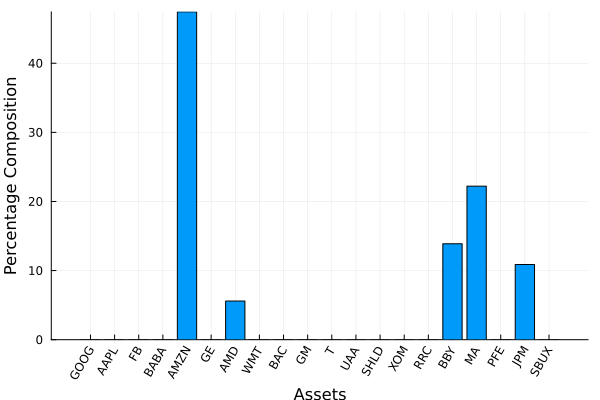

In [16]:
fig1 = plot_bar(portfolio)

# Compute the efficient frontier

The efficient frontier is a dictionary, whose key is the risk measure used. This dictionary contains information on the parameters used as well as the values for the risk and a dataframe of the weights for each asset at every point used.

The default arguments compute 20 points plus the maximum risk adjusted return ratio as the last column.

In [17]:
frontier = efficient_frontier(portfolio; points = 50)
frontier[:SD]

Dict{Symbol, Any} with 8 entries:
  :risk    => [0.0077046, 0.00837589, 0.00904717, 0.00971846, 0.0103898, 0.0110…
  :sharpe  => true
  :weights => 20×52 DataFrame…
  :class   => :Classic
  :points  => 50
  :rf      => 0.0
  :hist    => 1
  :kelly   => :None

In [18]:
pretty_table(frontier[:SD][:weights]; formatters=wdffmt)

┌─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┐
│ tickers │       1 │       2 │       3 │       4 │       5 │       6 │       7 │       8 │       9 │      10 │      11 │      12 │      13 │      14 │      15 │      16 │      17 │      18 │      19 │      20 │      21 │      22 │      23 │      24 │      25 │      26 │      27 │      28 │      29 │      30 │      31 │      32 │      33 │      34 │      35 │      36 │      37 │      38 │      39 │      40 │      41 │      42 │      43 │      44 │      45 │      46 │      4

We can plot the efficient frontier.

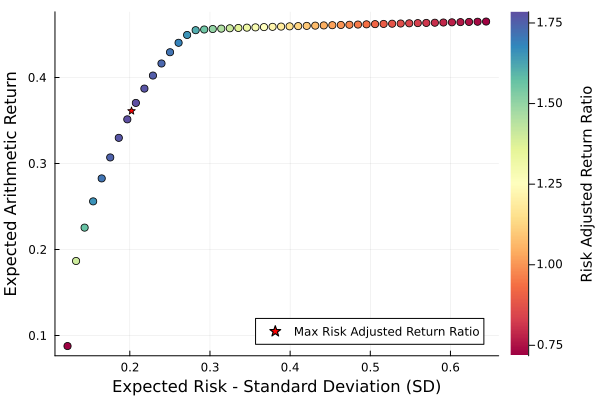

In [19]:
fig2 = plot_frontier(portfolio)

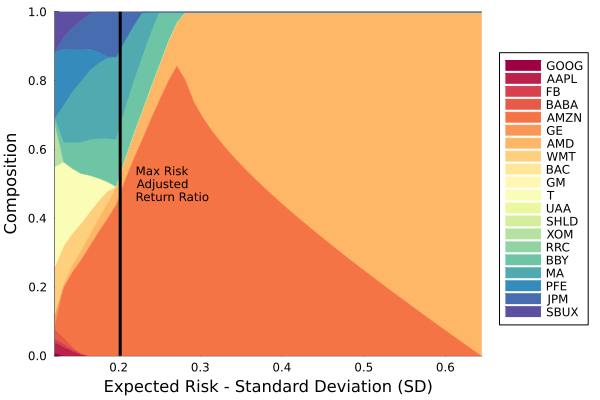

In [20]:
fig3 = plot_frontier_area(portfolio)